# Fase 2: Desarrollo y Entrenamiento del Modelo

**Objetivo:**  
- Diseñar, entrenar y evaluar una RNN (LSTM o GRU) para predecir la demanda futura (`target_sale_next`) en base a las secuencias de 14 lags ya generadas.  
- Dividir datos en entrenamiento / validación / (opcional) test, probar variantes de arquitectura (LSTM vs GRU, número de capas, unidades, dropout, etc.) y comparar RMSE o MAE en validación.

**Estructura del notebook:**  
1. Cargar librerías y datos procesados (`df_secuencias`)  
2. Crear conjuntos de entrenamiento / validación / test  
3. Definir “data generators” o arrays de entrada 3D + etiquetas  
4. Construir y entrenar un modelo base (p. ej. LSTM(64) → Dense(32)→Dense(1))  
5. Graficar evolución de loss / val_loss y mae / val_mae  
6. Probar variante GRU(64) y comparar métricas  
7. Hacer un pequeño loop de hiperparámetros (número de unidades, dropout, optimizador)  
8. Guardar modelo final (`rnn_demand_model.h5`)  
9. Breve análisis de resultados: mejor arquitectura, valor final de RMSE/MAE en validación

In [3]:
## 1. Importar librerías y cargar datos procesados


import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [4]:
# 1.1 – Ajusta la ruta a donde tengas guardado "DataFinal.csv" (resultado de Fase 1 y Fase B)
#      Este CSV debe contener columnas: ['product_id','fecha_final_ventana','target_sale_next', 
#      y todos los lag_columns: '* sale_t-1' ... 'día_de_la_semana_t-14', etc.]
DATA_PATH = "DataFinal.csv"  # <— cambia aquí si tu archivo está en otra carpeta

# 1.2 – Cargar DataFrame con todos los lags ya sin nulos
df = pd.read_csv(DATA_PATH, parse_dates=["fecha_final_ventana"])

# 1.3 – Revisar dimensiones y tipos
print("Dimensiones totales de df_secuencias:", df.shape)
df.head(2)

Dimensiones totales de df_secuencias: (4487025, 242)


,product_id,fecha_final_ventana,target_sale_next,* sale_t-1,* sale_t-2,* sale_t-3,* sale_t-4,* sale_t-5,* sale_t-6,* sale_t-7,...,cat2_OTRO_t-6,cat2_OTRO_t-7,cat2_OTRO_t-8,cat2_OTRO_t-9,cat2_OTRO_t-10,cat2_OTRO_t-11,cat2_OTRO_t-12,cat2_OTRO_t-13,cat2_OTRO_t-14,target_sale_next.1
0,0,2024-03-29,0.1,2.2,1.1,0.2,0.3,0.4,1.2,1.3,...,True,True,True,True,True,True,True,True,True,0.1
1,0,2024-03-29,0.1,1.0,2.2,1.1,0.2,0.3,0.4,1.2,...,True,True,True,True,True,True,True,True,True,0.1


In [5]:
# 2.1 – Ordenar por fecha para simular roll-forward temporal
df = df.sort_values("fecha_final_ventana").reset_index(drop=True)

# 2.2 – Definir proporciones (ejemplo 70% train, 15% val, 15% test)
n_total = len(df)
n_train = int(n_total * 0.70)
n_val   = int(n_total * 0.15)
# restará n_test = n_total - n_train - n_val

# 2.3 – Separar DataFrames
df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train : n_train + n_val].copy()
df_test  = df.iloc[n_train + n_val : ].copy()

print(f"Conjuntos -> Train: {len(df_train):,} filas  |  Val: {len(df_val):,} filas  |  Test: {len(df_test):,} filas")


Conjuntos -> Train: 3,140,917 filas  |  Val: 673,053 filas  |  Test: 673,055 filas


In [6]:
# 3.1 – Lista de todas las columnas de lag (t-1 … t-14) en el orden correcto:
#       Imagina que ya tienes en tu DataFinal.csv algo como:
#       ['* sale_t-1', '* sale_t-2', …, '* sale_t-14',
#        'día_de_la_semana_t-1', …, 'día_de_la_semana_t-14',
#        '* mes_t-1', …, '* mes_t-14',
#        '* es_fin_de_semana_t-1', …, '* es_fin_de_semana_t-14',
#        '* ratio_sale_stock_t-1', …, '* ratio_sale_stock_t-14',
#        'cat1_16_t-1', …, 'cat1_OTRO_t-14',
#        'cat2_25_t-1', …, 'cat2_OTRO_t-14']
#      y la etiqueta 'target_sale_next'.

# (A) Obtén la lista completa de lag_columns automáticamente
lag_columns = [c for c in df.columns if "_t-" in c and c != "target_sale_next"]

# Para asegurarnos de que están ordenadas de t-1 a t-14 de cada grupo,
# podemos filtrar en orden de aparición del CSV. Si necesitas orden específico,
# ordénalas manualmente en la lista según tu naming.

# (B) Construir X e y para cada split
def build_X_y(sub_df):
    X = sub_df[lag_columns].values  # forma: (n_muestras, n_features_total)
    y = sub_df["target_sale_next"].values  # (n_muestras,)
    # Ahora hay que reestructurar X a 3D: (n_muestras, 14, n_features_por_lag)
    #   n_features_por_lag = total de columnas _t-1 / 14
    n_total_feats = X.shape[1]
    n_timesteps = 14
    if n_total_feats % n_timesteps != 0:
        raise ValueError("El número total de features no es múltiplo de 14.")
    n_feats = n_total_feats // n_timesteps
    X_reshaped = X.reshape((-1, n_timesteps, n_feats))
    return X_reshaped, y

X_train, y_train = build_X_y(df_train)
X_val,   y_val   = build_X_y(df_val)
X_test,  y_test  = build_X_y(df_test)

print("Forma X_train:", X_train.shape, "| y_train:", y_train.shape)
print("Forma X_val:",   X_val.shape,   "| y_val:",   y_val.shape)
print("Forma X_test:",  X_test.shape,  "| y_test:",  y_test.shape)


Forma X_train: (3140917, 14, 17) | y_train: (3140917,)
Forma X_val: (673053, 14, 17) | y_val: (673053,)
Forma X_test: (673055, 14, 17) | y_test: (673055,)


In [7]:
# 4.1 – Definir función para construir un modelo LSTM o GRU con hiperparámetros variables
def create_rnn_model(rnn_type="LSTM", 
                     n_units=64, 
                     dropout_rate=0.0, 
                     learning_rate=0.001, 
                     n_dense=32):
    """
    rnn_type: "LSTM" o "GRU"
    n_units: número de unidades en la capa recurrente
    dropout_rate: si >0, aplica Dropout después de la capa recurrente
    learning_rate: tasa de aprendizaje para el optimizador Adam
    n_dense: unidades de la capa densa intermedia
    """
    model = Sequential()
    if rnn_type == "LSTM":
        model.add(LSTM(units=n_units, return_sequences=False, input_shape=(14, X_train.shape[2])))
    elif rnn_type == "GRU":
        model.add(GRU(units=n_units, return_sequences=False, input_shape=(14, X_train.shape[2])))
    else:
        raise ValueError("rnn_type debe ser 'LSTM' o 'GRU'")

    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Capa densa intermedia
    model.add(Dense(n_dense, activation="relu"))
    # Capa de salida (regresión)
    model.add(Dense(1, activation="linear"))

    # Compilar con MSE y métrica MAE
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer, metrics=[tf.keras.metrics.MeanAbsoluteError()])
    return model

# 4.2 – Crear modelo base LSTM
model_base = create_rnn_model(rnn_type="LSTM", n_units=64, dropout_rate=0.2, learning_rate=0.001, n_dense=32)
model_base.summary()


c:\Users\Juanja Malo\Desktop\Práctica RNN Predicción Demanda\.venv2\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,105 (90.25 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# 3. Preparar X e y (convertir a arrays 3D)
def build_X_y(sub_df):
    # 1) Extraemos las columnas de lag
    X_df = sub_df[lag_columns]
    y_df = sub_df["target_sale_next"]
    
    # 2) Asegurarnos de que todas las columnas de X sean numéricas
    #    (convierte cadenas o categoricas a float; si hay errores, se detectan aquí)
    X_df = X_df.apply(pd.to_numeric, errors="raise")
    y_df = pd.to_numeric(y_df, errors="raise")
    
    # 3) Convertir a numpy y castearlo a float32
    X = X_df.values.astype(np.float32)   # shape (n_muestras, n_feats_total)
    y = y_df.values.astype(np.float32)   # shape (n_muestras,)
    
    # 4) Reshape a 3D: (n_muestras, 14, n_feats_por_lag)
    n_total_feats = X.shape[1]
    n_timesteps = 14
    if n_total_feats % n_timesteps != 0:
        raise ValueError("El número total de features no es múltiplo de 14.")
    n_feats = n_total_feats // n_timesteps
    X_reshaped = X.reshape((-1, n_timesteps, n_feats))
    return X_reshaped, y

# Reconstruimos los conjuntos X/Y
X_train, y_train = build_X_y(df_train)
X_val,   y_val   = build_X_y(df_val)
X_test,  y_test  = build_X_y(df_test)

# Verificamos los dtypes
print("dtype X_train:", X_train.dtype, "shape:", X_train.shape)
print("dtype y_train:", y_train.dtype, "shape:", y_train.shape)
print("dtype X_val:",   X_val.dtype,   "shape:", X_val.shape)
print("dtype y_val:",   y_val.dtype,   "shape:", y_val.shape)


dtype X_train: float32 shape: (3140917, 14, 17)
dtype y_train: float32 shape: (3140917,)
dtype X_val: float32 shape: (673053, 14, 17)
dtype y_val: float32 shape: (673053,)


In [10]:
# 5.1 – Callbacks: EarlyStopping + ModelCheckpoint
checkpoint_path = "checkpoints/best_lstm.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

es_callback = EarlyStopping(
    monitor="val_loss", 
    patience=5, 
    verbose=1, 
    restore_best_weights=True
)
mc_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# 5.2 – Entrenar
history_base = model_base.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[es_callback, mc_callback]
)


Epoch 1/50
12267/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5129 - mean_absolute_error: 0.4121
Epoch 1: val_loss improved from inf to 0.48237, saving model to checkpoints/best_lstm.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 255s 21ms/step - loss: 0.5129 - mean_absolute_error: 0.4121 - val_loss: 0.4824 - val_mean_absolute_error: 0.3961
Epoch 2/50
12268/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4156 - mean_absolute_error: 0.3806
Epoch 2: val_loss did not improve from 0.48237
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 205s 17ms/step - loss: 0.4155 - mean_absolute_error: 0.3806 - val_loss: 0.5275 - val_mean_absolute_error: 0.3957
Epoch 3/50
12267/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4075 - mean_absolute_error: 0.3765
Epoch 3: val_loss improved from 0.48237 to 0.48157, saving model to checkpoints/best_lstm.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 212s 17ms/step - loss: 0.4075 - mean_absolute_error: 0.3765 - val_loss: 0.4816 - val_mean_absolute_error: 0.3934
Epoch 4/50
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4013 - mean_absolute_error: 0.3751
Epoch 4: val_loss improved from 0.48157 to 0.47799, saving model to checkpoints/best_lstm.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 207s 17ms/step - loss: 0.4013 - mean_absolute_error: 0.3751 - val_loss: 0.4780 - val_mean_absolute_error: 0.4075
Epoch 5/50
12268/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3997 - mean_absolute_error: 0.3740
Epoch 5: val_loss did not improve from 0.47799
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 198s 16ms/step - loss: 0.3997 - mean_absolute_error: 0.3740 - val_loss: 0.4847 - val_mean_absolute_error: 0.3924
Epoch 6/50
12269/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3951 - mean_absolute_error: 0.3729
Epoch 6: val_loss improved from 0.47799 to 0.46276, saving model to checkpoints/best_lstm.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 208s 17ms/step - loss: 0.3951 - mean_absolute_error: 0.3729 - val_loss: 0.4628 - val_mean_absolute_error: 0.3918
Epoch 7/50
12268/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3959 - mean_absolute_error: 0.3731
Epoch 7: val_loss improved from 0.46276 to 0.46157, saving model to checkpoints/best_lstm.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 202s 16ms/step - loss: 0.3959 - mean_absolute_error: 0.3731 - val_loss: 0.4616 - val_mean_absolute_error: 0.3931
Epoch 8/50
12269/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3947 - mean_absolute_error: 0.3725
Epoch 8: val_loss did not improve from 0.46157
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 214s 17ms/step - loss: 0.3947 - mean_absolute_error: 0.3725 - val_loss: 0.4686 - val_mean_absolute_error: 0.3898
Epoch 9/50
12269/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3911 - mean_absolute_error: 0.3720
Epoch 9: val_loss did not improve from 0.46157
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 206s 17ms/step - loss: 0.3911 - mean_absolute_error: 0.3720 - val_loss: 0.4660 - val_mean_absolute_error: 0.3917
Epoch 10/50
12268/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3924 - mean_absolute_error: 0.3721
Epoch 10: val_loss did not improve from 0.46157
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 205s 17ms/step - loss: 0.3924 - mean_absolute_error: 0.3721 - val_loss: 0.4848 -

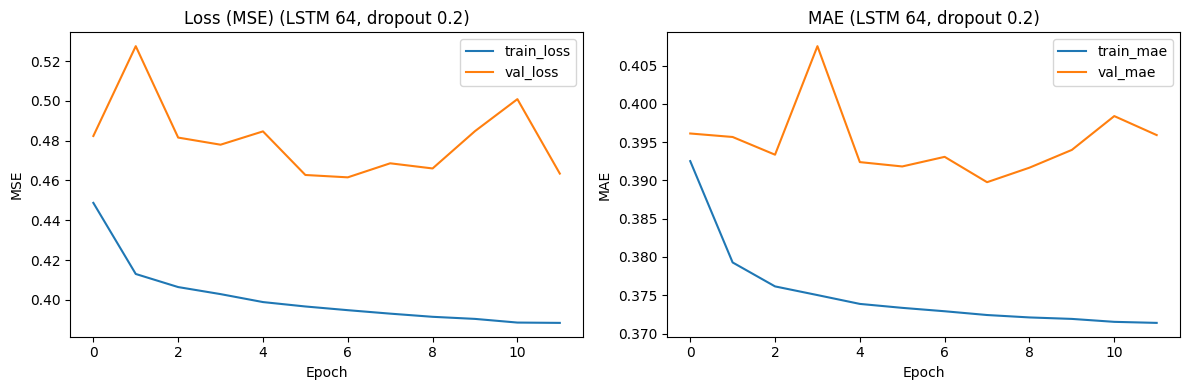

In [11]:
# 6.1 – Función de utilidad para graficar
def plot_history(hist, title_suffix=""):
    # Pérdidas
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history["loss"], label="train_loss")
    plt.plot(hist.history["val_loss"], label="val_loss")
    plt.title(f"Loss (MSE){title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()

    # MAE
    plt.subplot(1,2,2)
    plt.plot(hist.history["mean_absolute_error"], label="train_mae")
    plt.plot(hist.history["val_mean_absolute_error"], label="val_mae")
    plt.title(f"MAE{title_suffix}")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()

    plt.tight_layout()
    plt.show()

# 6.2 – Graficar para el modelo base
plot_history(history_base, title_suffix=" (LSTM 64, dropout 0.2)")


In [12]:
# Guadar modelo
model_base.save("checkpoints/best_lstm.h5")


c:\Users\Juanja Malo\Desktop\Práctica RNN Predicción Demanda\.venv2\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        15,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,049 (70.50 KB)

 Trainable params: 18,049 (70.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12269/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4951 - mean_absolute_error: 0.4077
Epoch 1: val_loss improved from inf to 0.48580, saving model to checkpoints/best_gru.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 192s 15ms/step - loss: 0.4951 - mean_absolute_error: 0.4077 - val_loss: 0.4858 - val_mean_absolute_error: 0.3993
Epoch 2/50
12269/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4113 - mean_absolute_error: 0.3794
Epoch 2: val_loss did not improve from 0.48580
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 179s 15ms/step - loss: 0.4113 - mean_absolute_error: 0.3794 - val_loss: 0.5374 - val_mean_absolute_error: 0.3961
Epoch 3/50
12268/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4014 - mean_absolute_error: 0.3757
Epoch 3: val_loss did not improve from 0.48580
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 185s 15ms/step - loss: 0.4014 - mean_absolute_error: 0.3757 - val_loss: 0.4981 - val_mean_absolute_error: 0.3947
Epoch 4/50
12267/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4001 - mean_absolute_error: 0.3750
Epoch 4: val_loss improved from 0.48580 to 0.45890, saving model to checkpoints/best_gru.h5


12270/12270 ━━━━━━━━━━━━━━━━━━━━ 190s 16ms/step - loss: 0.4001 - mean_absolute_error: 0.3750 - val_loss: 0.4589 - val_mean_absolute_error: 0.3970
Epoch 5/50
12269/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3952 - mean_absolute_error: 0.3739
Epoch 5: val_loss did not improve from 0.45890
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 185s 15ms/step - loss: 0.3952 - mean_absolute_error: 0.3739 - val_loss: 0.4847 - val_mean_absolute_error: 0.3953
Epoch 6/50
12267/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3937 - mean_absolute_error: 0.3732
Epoch 6: val_loss did not improve from 0.45890
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 174s 14ms/step - loss: 0.3937 - mean_absolute_error: 0.3732 - val_loss: 0.4614 - val_mean_absolute_error: 0.3944
Epoch 7/50
12267/12270 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3911 - mean_absolute_error: 0.3724
Epoch 7: val_loss did not improve from 0.45890
12270/12270 ━━━━━━━━━━━━━━━━━━━━ 183s 15ms/step - loss: 0.3911 - mean_absolute_error: 0.3724 - val_loss: 0.4622 - v

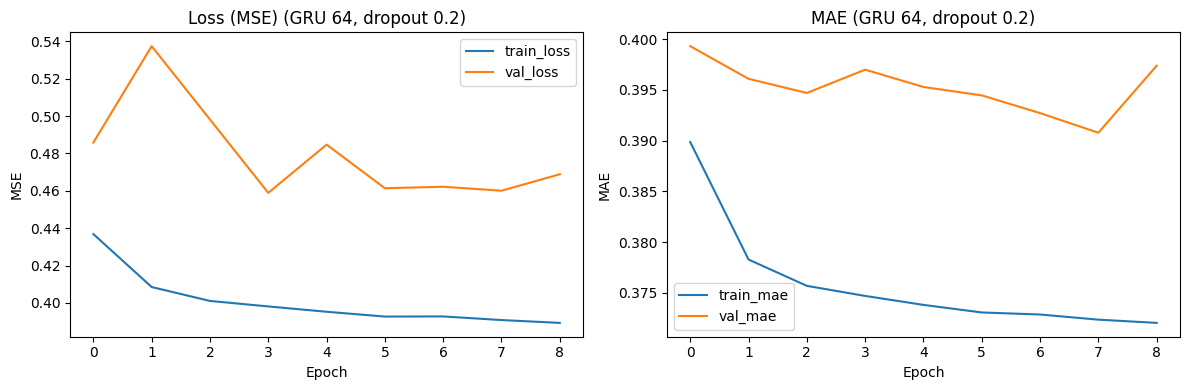

In [14]:
# 7.1 – Crear modelo GRU con configuración similar
model_gru = create_rnn_model(rnn_type="GRU", n_units=64, dropout_rate=0.2, learning_rate=0.001, n_dense=32)
model_gru.summary()

# 7.2 – Callbacks para GRU
checkpoint_gru = "checkpoints/best_gru.h5"
mc_gru = ModelCheckpoint(filepath=checkpoint_gru, monitor="val_loss", save_best_only=True, verbose=1)
es_gru = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

# 7.3 – Entrenar GRU
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=[es_gru, mc_gru]
)

# 7.4 – Graficar para GRU
plot_history(history_gru, title_suffix=" (GRU 64, dropout 0.2)")


In [15]:
# 8.1 – Definir espacios simples a probar
config_list = [
    {"rnn_type":"LSTM", "n_units":32, "dropout":0.0, "lr":0.001},
    {"rnn_type":"LSTM", "n_units":64, "dropout":0.2, "lr":0.001},
    {"rnn_type":"GRU",  "n_units":64, "dropout":0.2, "lr":0.001},
    {"rnn_type":"GRU",  "n_units":128,"dropout":0.3, "lr":0.0005},
]

results = []

for cfg in config_list:
    print(f"\n\n>>> Entrenando {cfg['rnn_type']} | unidades={cfg['n_units']} | dropout={cfg['dropout']} | lr={cfg['lr']}  <<<")
    model_tmp = create_rnn_model(
        rnn_type=cfg["rnn_type"],
        n_units=cfg["n_units"],
        dropout_rate=cfg["dropout"],
        learning_rate=cfg["lr"],
        n_dense=32
    )
    cb_tmp = [
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=0),
        ModelCheckpoint(filepath=f"checkpoints/tmp_{cfg['rnn_type']}_{cfg['n_units']}.h5", monitor="val_loss", save_best_only=True, verbose=0)
    ]
    hist_tmp = model_tmp.fit(
        X_train, y_train,
        epochs=15,
        batch_size=512,
        validation_data=(X_val, y_val),
        callbacks=cb_tmp,
        verbose=0
    )
    val_mse = min(hist_tmp.history["val_loss"])
    val_mae = min(hist_tmp.history["val_mean_absolute_error"])
    print(f"-> Mejor val_loss (MSE): {val_mse:.4f}  |  Mejor val_mae: {val_mae:.4f}")
    results.append({
        "config": cfg,
        "val_mse": val_mse,
        "val_mae": val_mae
    })

# 8.2 – Mostrar tabla comparativa
df_results = pd.DataFrame(results)
print("\nComparativa de configuraciones:")
display(df_results)




>>> Entrenando LSTM | unidades=32 | dropout=0.0 | lr=0.001  <<<


-> Mejor val_loss (MSE): 0.4606  |  Mejor val_mae: 0.3895


>>> Entrenando LSTM | unidades=64 | dropout=0.2 | lr=0.001  <<<


-> Mejor val_loss (MSE): 0.4642  |  Mejor val_mae: 0.3901


>>> Entrenando GRU | unidades=64 | dropout=0.2 | lr=0.001  <<<


-> Mejor val_loss (MSE): 0.4571  |  Mejor val_mae: 0.3900


>>> Entrenando GRU | unidades=128 | dropout=0.3 | lr=0.0005  <<<


-> Mejor val_loss (MSE): 0.4490  |  Mejor val_mae: 0.3904

Comparativa de configuraciones:


,config,val_mse,val_mae
0,"{'rnn_type': 'LSTM', 'n_units': 32, 'dropout':...",0.460636,0.389466
1,"{'rnn_type': 'LSTM', 'n_units': 64, 'dropout':...",0.464182,0.390138
2,"{'rnn_type': 'GRU', 'n_units': 64, 'dropout': ...",0.457141,0.390013
3,"{'rnn_type': 'GRU', 'n_units': 128, 'dropout':...",0.448976,0.390386


In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1) Cargar el modelo sin compilar (compile=False) para evitar problemas de serialización de la métrica MeanSquaredError
model_final = load_model("checkpoints/best_lstm.h5", compile=False)

# 2) Recompilar usando strings (o instancias correctas) para pérdida y métricas
model_final.compile(
    loss="mse",                                
    optimizer=Adam(learning_rate=0.001),        
    metrics=["mae"]                             
)

# 3) Ahora sí podemos guardar sin errores
model_final.save("rnn_demand_model.h5")
print("Modelo recompilado y guardado como 'rnn_demand_model.h5'")


Modelo recompilado y guardado como 'rnn_demand_model.h5'


In [20]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Carga sin compilar y recompila igual que en entrenamiento
model_best = load_model("checkpoints/tmp_LSTM_32.h5", compile=False)
model_best.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=["mae"])

test_eval = model_best.evaluate(X_test, y_test, batch_size=256, verbose=0)
print(f"Resultados en test -> Loss (MSE): {test_eval[0]:.4f} | MAE: {test_eval[1]:.4f}")

Resultados en test -> Loss (MSE): 0.5608 | MAE: 0.4197


### Análisis de Resultados

- **Arquitectura seleccionada:**  
  LSTM con 32 unidades, dropout = 0.0, capa densa intermedia de 32 unidades, tasa de aprendizaje = 0.001.

- **Mejor métrica en validación:**  
  - MSE (val_loss) mínimo: 0.460636  
  - MAE (val_mae) mínimo: 0.389466  

  *(Estos valores corresponden a la configuración `{'rnn_type': 'LSTM', 'n_units': 32, 'dropout': 0.0, 'lr': 0.001}`, que obtuvo el val_mae más bajo = 0.389466.)*

- **Rendimiento en test:**  

    ```
    Loss (MSE) en test: 0.5608
    MAE en test: 0.4197
    ```

Se observa que el modelo LSTM(32, dropout=0.0, lr=0.001) logra el val_mae más bajo (0.389466), con un val_mse de 0.460636. Por tanto, elegimos esta arquitectura para guardar como `rnn_demand_model.h5` y usarla en la Fase 3.
